In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
from os import listdir
from os.path import isfile, join
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls



drive  sample_data


In [4]:
#fpath = '../../DataSets/FVCell-Classification-Segmentation/Policristal/' # Remember: ../ means outside current folder
fpath = 'drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/'

In [5]:
!ls

drive  sample_data


In [6]:
files_F = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)]

In [7]:
files_F

#Onak is the good ones - Ok
#Txarrak are the bad ones - Not OK

[]

In [8]:
len(files_F)

0

In [9]:
fname = files_F[300]
print(fname, len(files_F))
img = cv2.imread(fname,0)/255.

plt.figure(figsize=(15, 15))
#plt.subplot(221)
plt.imshow(img)
plt.show()
print(img.shape, img.max())

w = 512
h = 512
dim = (w, h)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.figure(figsize=(15, 15))
#plt.subplot(221)
plt.imshow(resized)
plt.show()
print(resized.shape, resized.max())

IndexError: ignored

In [ ]:
w = 256 #512
h = 256 #512
x_train = np.zeros((len(files_F),w,h,1))
y_train = np.zeros(len(files_F))
for i,nm in enumerate(files_F): #[:2]:
    img = cv2.imread(nm,0)/255. 
    dim = (w, h)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    x_train[i,:,:,0]=resized
    
    if False:
        plt.subplot(121)
        plt.imshow(resized)
        plt.subplot(122)
        plt.imshow(x_train[i,:,:,0])
        plt.show()
    
    if ('Txarrak' in nm):
        y_train[i]=1
    
    print(i,nm, resized.shape)

    


    


0 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1051.bmp (256, 256)
1 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1050.bmp (256, 256)
2 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1028.bmp (256, 256)
3 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1030.bmp (256, 256)
4 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1031.bmp (256, 256)
5 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1032.bmp (256, 256)
6 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1029.bmp (256, 256)
7 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation/Txarrak/1033.bmp (256, 256)
8 drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policri

In [ ]:
id_shuf = np.argsort(np.random.rand(x_train.shape[0])) # Get indexes of the shorted values
x_train = x_train[id_shuf]
y_train = y_train[id_shuf]

In [ ]:
train_split=int(x_train.shape[0]*0.8) # Train with 80% of the database

x_test = x_train[train_split:]
y_test = y_train[train_split:] # En caso de multiclasiffier tendríamos varias "y" y varias salidas (o con un encoding)

x_train = x_train[:train_split]
y_train = y_train[:train_split]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) # Number of elements, rows, cols, channels

(280, 256, 256, 1) (280,) (70, 256, 256, 1) (70,)


In [ ]:
print(x_train[1,:,:,0].max(), x_train[1,:,:,0].min())

0.3047827209263147 0.03524359545654243


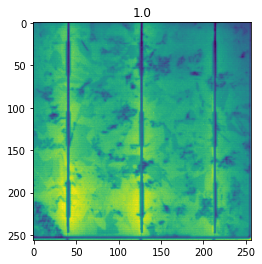

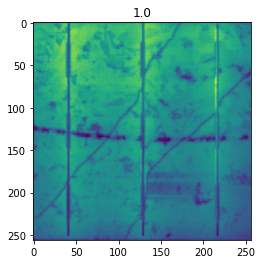

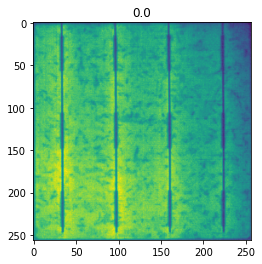

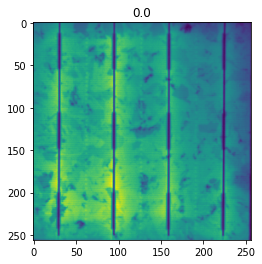

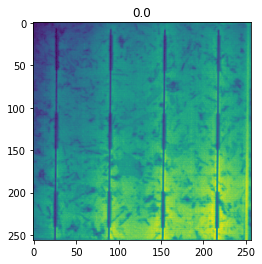

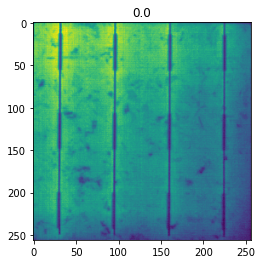

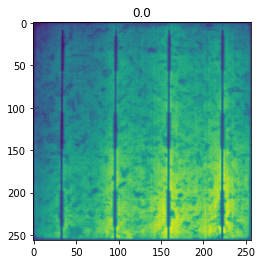

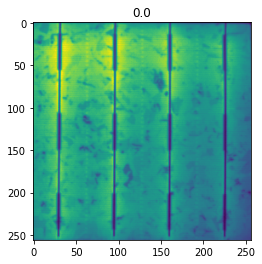

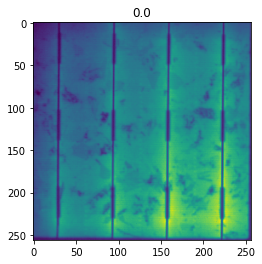

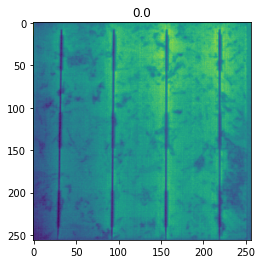

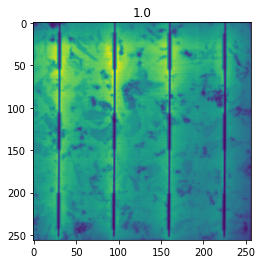

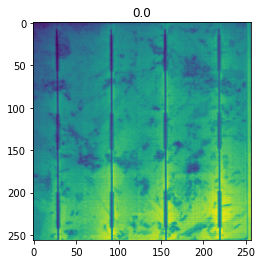

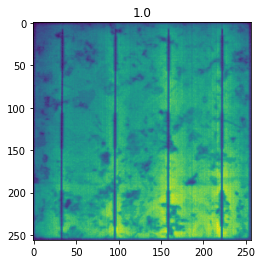

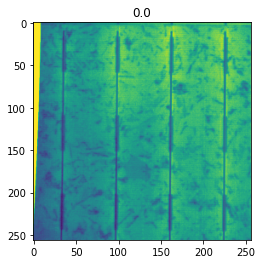

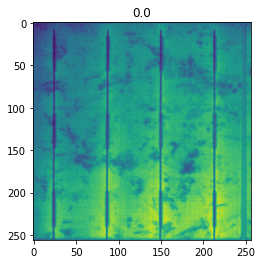

In [ ]:
for i in range(15):
    plt.imshow(x_train[i,:,:,0])
    plt.title(y_train[i])
    plt.show()

# Red con capa convolucional

# ImageDataGenerator

In [ ]:
#########################################################################3
##  PREPARE OUR DATA


# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-2
BATCH_SIZE = 16
NUM_EPOCHS = 50

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255)#,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Train',  # this is the target directory
        color_mode='grayscale',
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'drive/MyDrive/MS_RSC_DL_21-22/Master-RSC-DeepLearning/DataSets/Policristal/Validation',
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode='binary')


##########################################################################


Found 246 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
